In [49]:
library(tidyverse)
library(ggplot2)
library(factoextra)
library(reshape2)
library(umap)
library(ComplexHeatmap)
library(cluster)
library(dynamicTreeCut)
library(uwot)
library(RColorBrewer)
library(circlize)

In [446]:
#load_dir <- "ARS313/plot_data"
load_dir <- "ARS313"

In [536]:
#methylation_rep1 <- read_csv(paste(load_dir, "/ARS313_violinplots_annotation_v3.csv", sep=""))
#methylation_rep1 <- methylation_rep1[, -1]
#methylation_rep1$feature <- factor(methylation_rep1$feature, levels = c("-3ns", "-2ns", "-2L", "-1ns", "-1L",
#                                                                       "ARS313", "+1ns", "+2L", "+2ns", "+3ns"))
#methylation_rep1$condition <- factor(methylation_rep1$condition)

methylation_rep1 <- read_csv(paste(load_dir, "/ARS313_feature_methylation_annotation_v3.csv", sep=""))
methylation_rep1 <- methylation_rep1[, -1]
methylation_rep1$feature <- factor(methylation_rep1$feature, levels = c("-3ns", "-2ns", "-2L", "-1ns", "-1L",
                                                                       "ARS313", "+1ns", "+2L", "+2ns", "+3ns"))
methylation_rep1$condition <- factor(methylation_rep1$condition)
methylation_rep1$strand <- factor(methylation_rep1$strand)

New names:
* `` -> ...1

Rows: 87840 Columns: 7
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): strand, feature, condition, replicate
dbl (3): ...1, molecule, norm methylation

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [537]:
colnames(methylation_rep1)[4] <- "norm_methylation"

In [538]:
#methylation_long <- dcast(methylation_rep1, molecule + condition ~feature, value.var = "norm_methylation")
methylation_long <- dcast(methylation_rep1, molecule + condition + replicate + strand ~feature, value.var = "norm_methylation")

In [539]:
scaled_meth <- scale(methylation_long[,-(1:4)])

In [55]:
#define linkage methods
#m <- c( "average", "single", "complete", "ward")
#names(m) <- c( "average", "single", "complete", "ward")

#function to compute agglomerative coefficient
#ac <- function(x) {
#  agnes(scaled_meth, method = x)$ac
#}
#
#calculate agglomerative coefficient for each clustering linkage method
#sapply(m, ac)"""

In [455]:
pca_meth <- prcomp(scaled_meth)

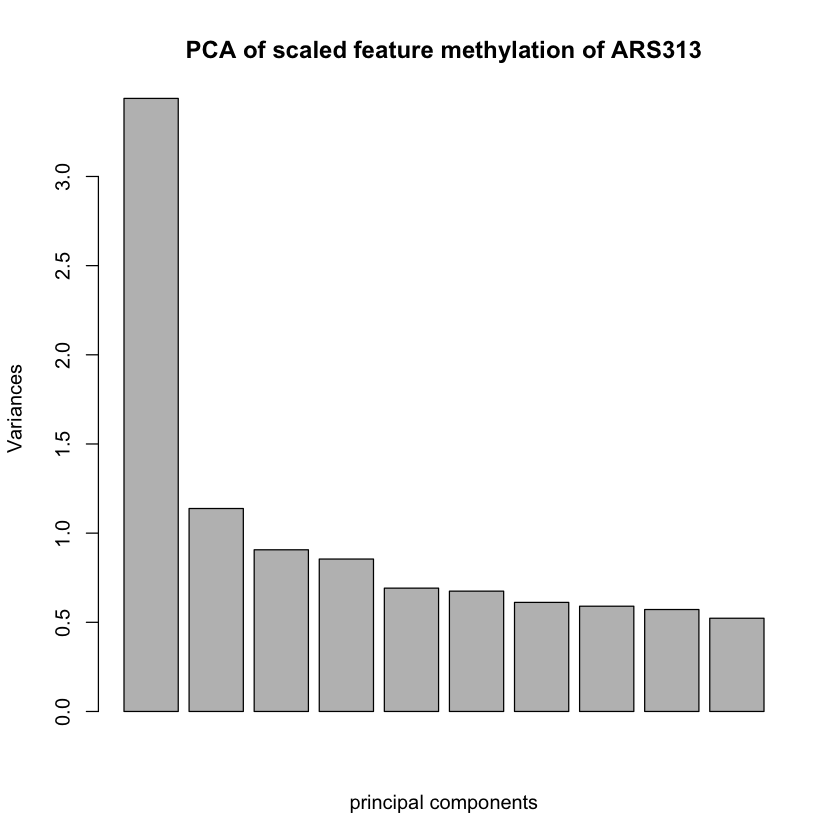

In [502]:
plot(pca_meth, main = "PCA of scaled feature methylation of ARS313", xlab = "principal components")

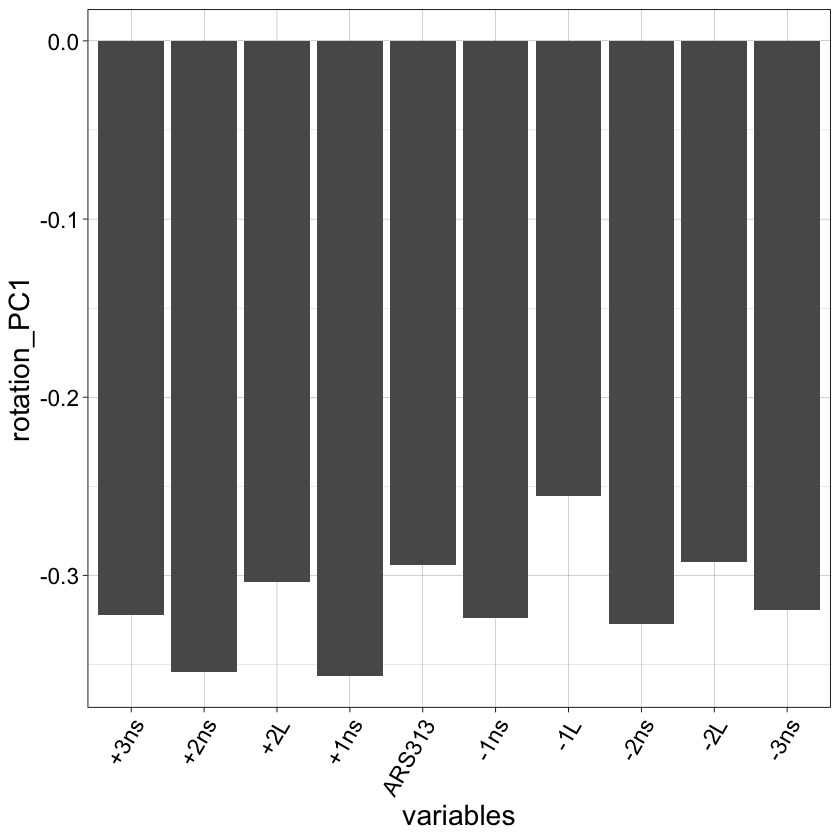

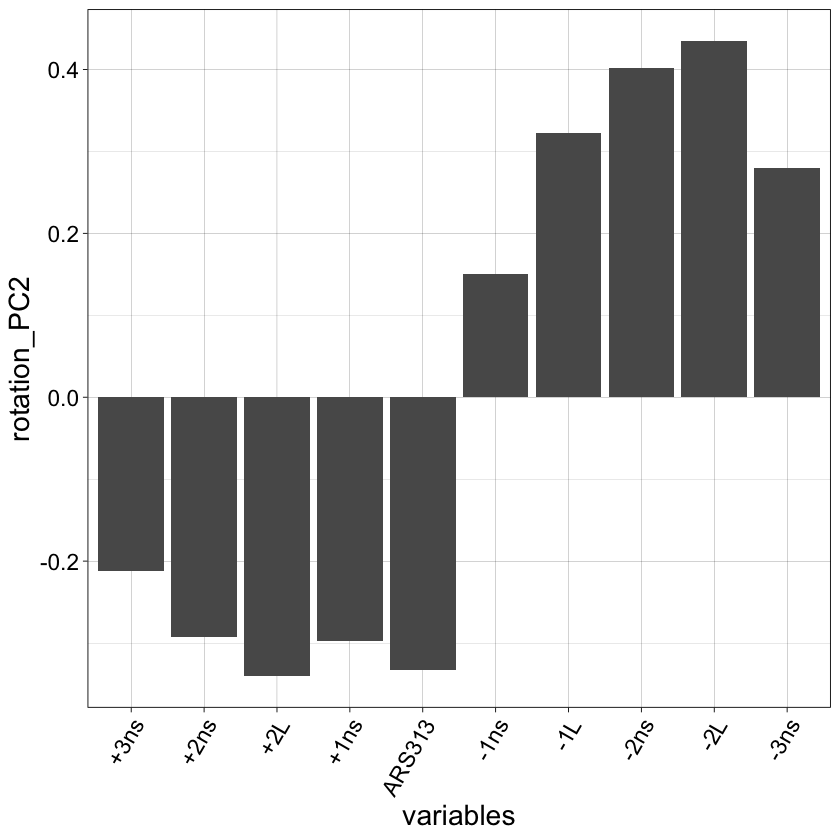

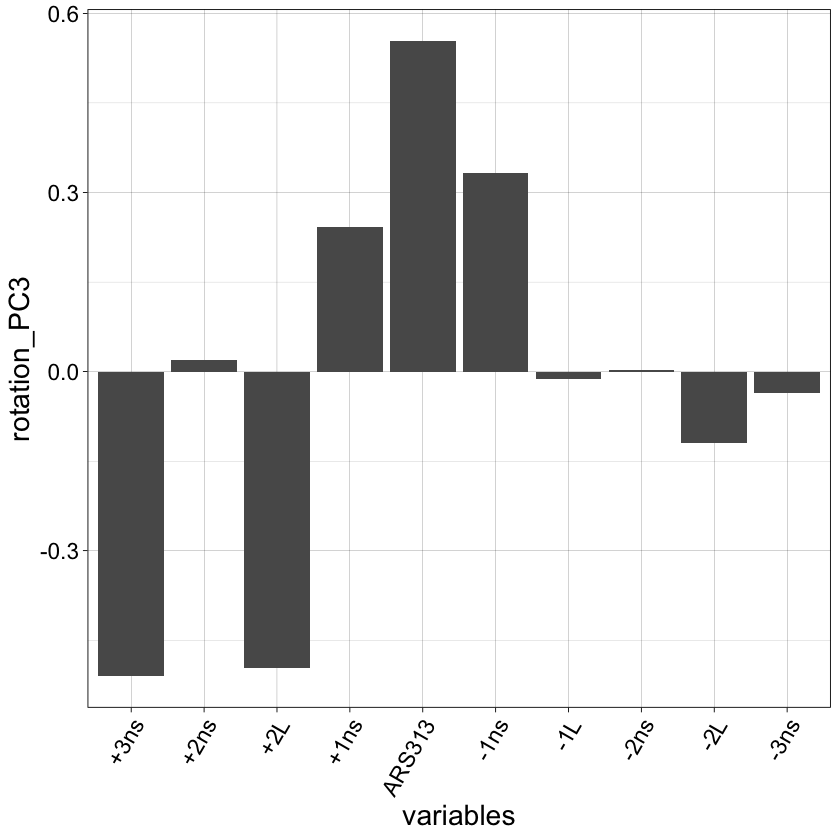

In [457]:
pca.summary <- summary(pca_meth)

df_plot <- data.frame("variables"= rownames(pca.summary$rotation),
                 "rotation_PC1" = pca.summary$rotation[,1],
                 "rotation_PC2" = pca.summary$rotation[,2],
                 "rotation_PC3" = pca.summary$rotation[,3])

df_plot$variables <- factor(df_plot$variables, levels = c("+3ns", "+2ns", "+2L", "+1ns", 
                                                          "ARS313", "-1ns", "-1L", "-2ns", "-2L", "-3ns"))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC1)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC2)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC3)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

In [56]:
clust <- agnes(scaled_meth, method = "ward")

In [57]:
clust$ac

[1] 0.9937979

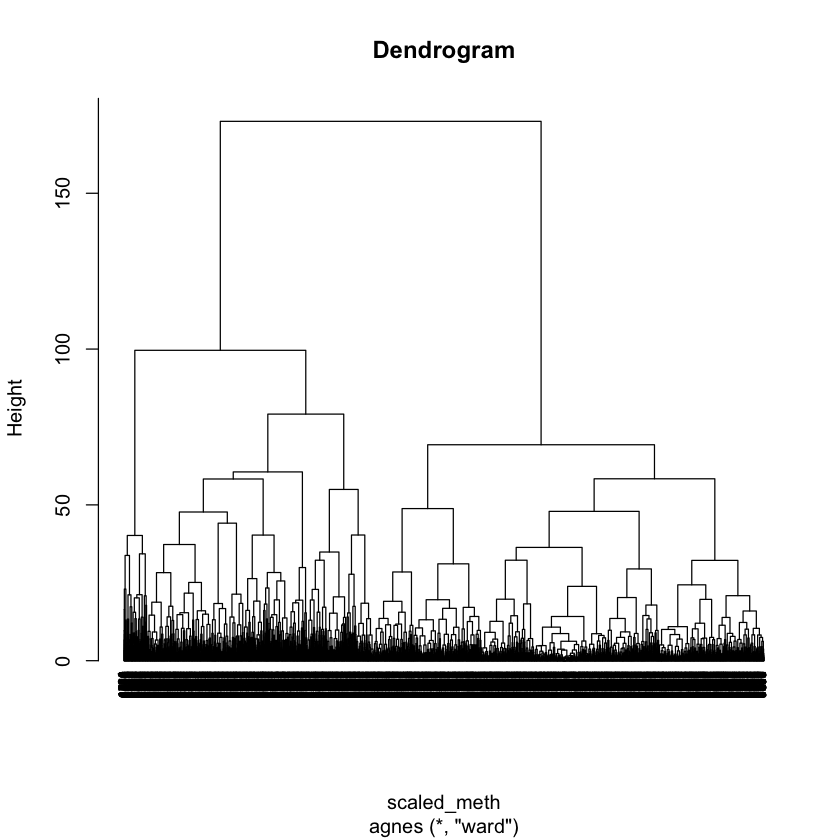

In [58]:
#produce dendrogram
pltree(clust, cex = 0.6, hang = -1, main = "Dendrogram")

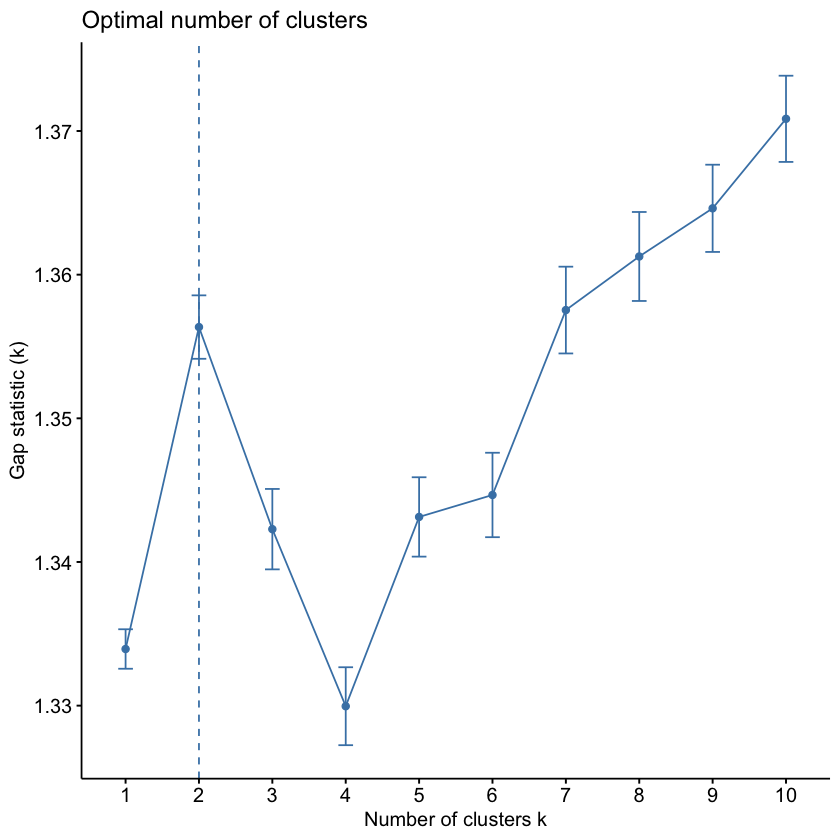

In [59]:
#This step is computationally very expensive. Avoid rerunning if possible (or run overnight)

#calculate gap statistic for each number of clusters (up to 10 clusters)
#gap_stat <- clusGap(scaled_meth, FUN = hcut, nstart = 25, K.max = 10, B = 50)

#produce plot of clusters vs. gap statistic
#fviz_gap_stat(gap_stat)

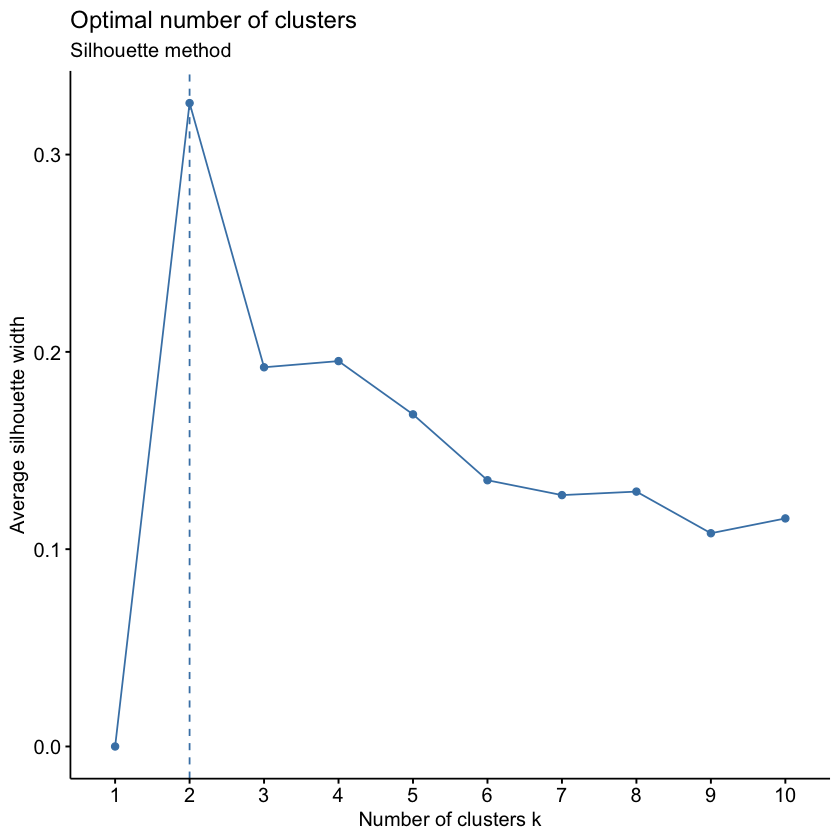

In [60]:
fviz_nbclust(scaled_meth, kmeans, method = "silhouette") +
  labs(subtitle = "Silhouette method")

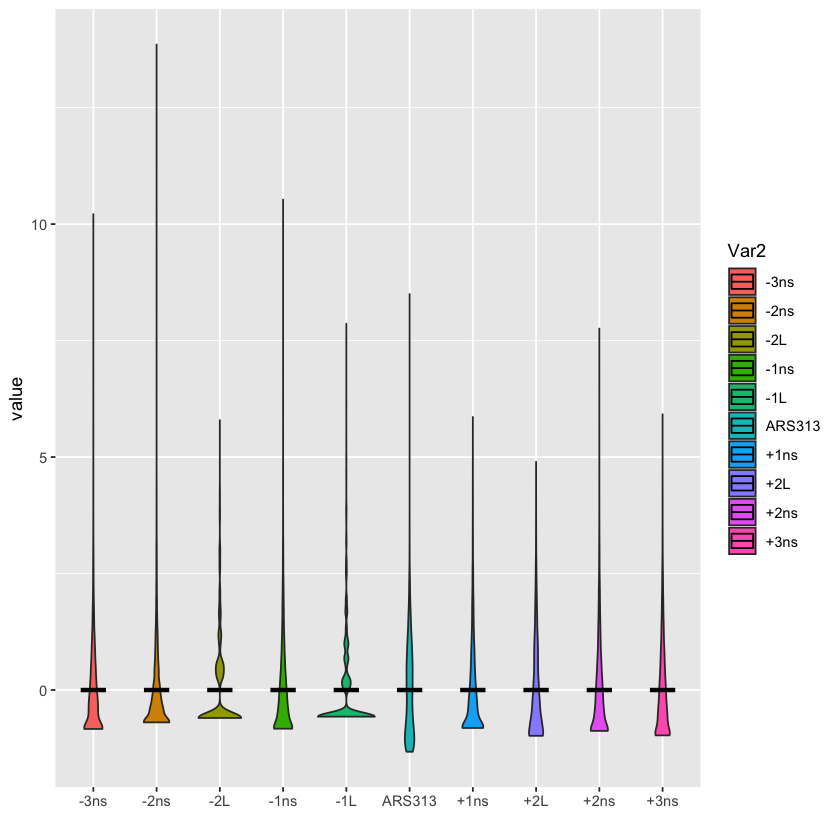

In [362]:
scaled_meth.melt <- melt(scaled_meth)

ggplot(scaled_meth.melt, aes(x = Var2, y = value, fill = Var2)) + 
geom_violin() + 
xlab("") + 
stat_summary(fun = "mean", geom = "crossbar", color = "black", width = 0.4)

In [542]:
#compute distance matrix
d <- dist(scaled_meth, method = "euclidean")

#perform hierarchical clustering using Ward's method
final_clust <- hclust(d, method = "ward.D2" )

#cut the dendrogram into 4 clusters
groups <- cutree(final_clust, k=4)
#groups <- cutreeDynamic(corr_clust, distM= as.matrix(d),
#                             method="hybrid", deepSplit = 0.05)

#find number of observations in each cluster
table(groups)

groups
   1    2    3    4 
 311 5363 2204  906 

In [543]:
aggr_data <- cbind(methylation_long, groups)

In [544]:
umap_scaled <- umap(scaled_meth, metric= "euclidean")

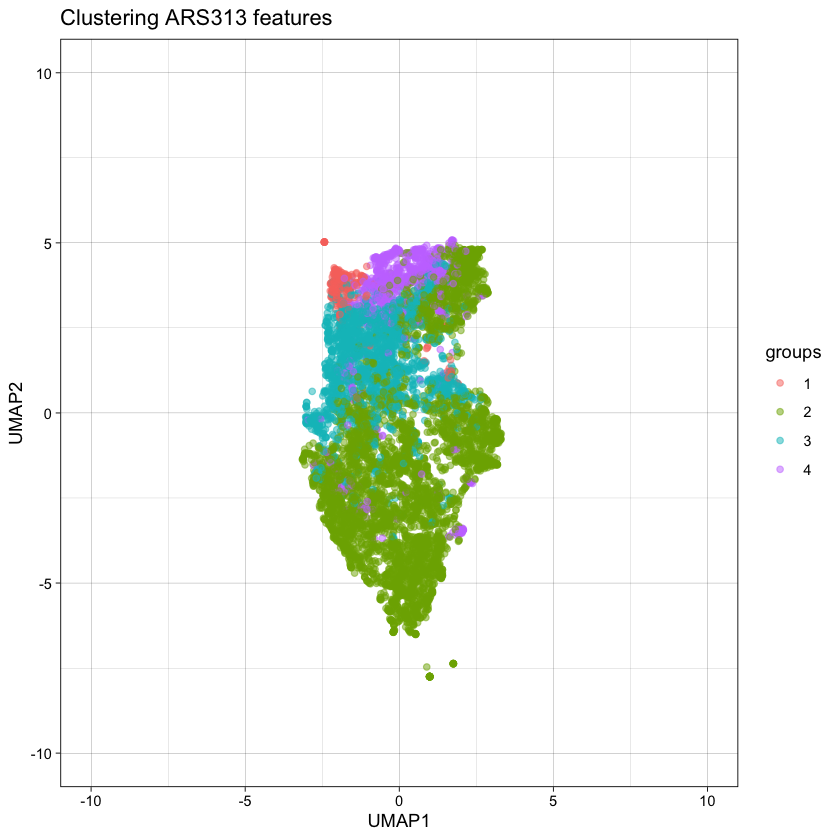

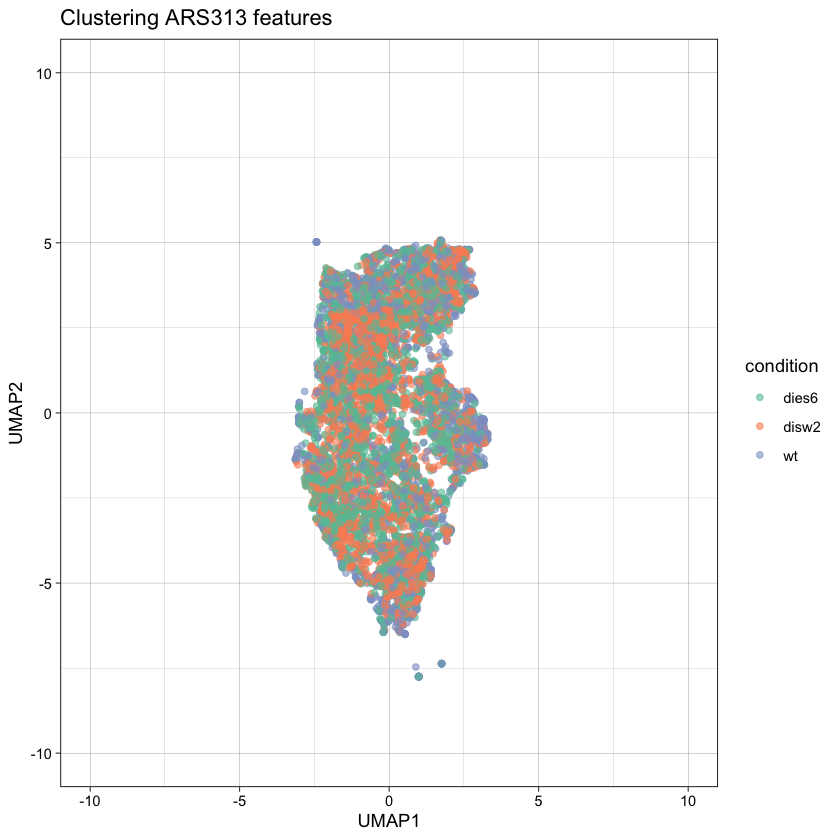

In [545]:
plot_data <- cbind(umap_scaled, aggr_data)
plot_data$groups <- factor(plot_data$groups)

colnames(plot_data)[1:2] = c("UMAP1", "UMAP2")

ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= groups)) + 
  theme_linedraw() + 
  geom_point(alpha = 0.5) +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

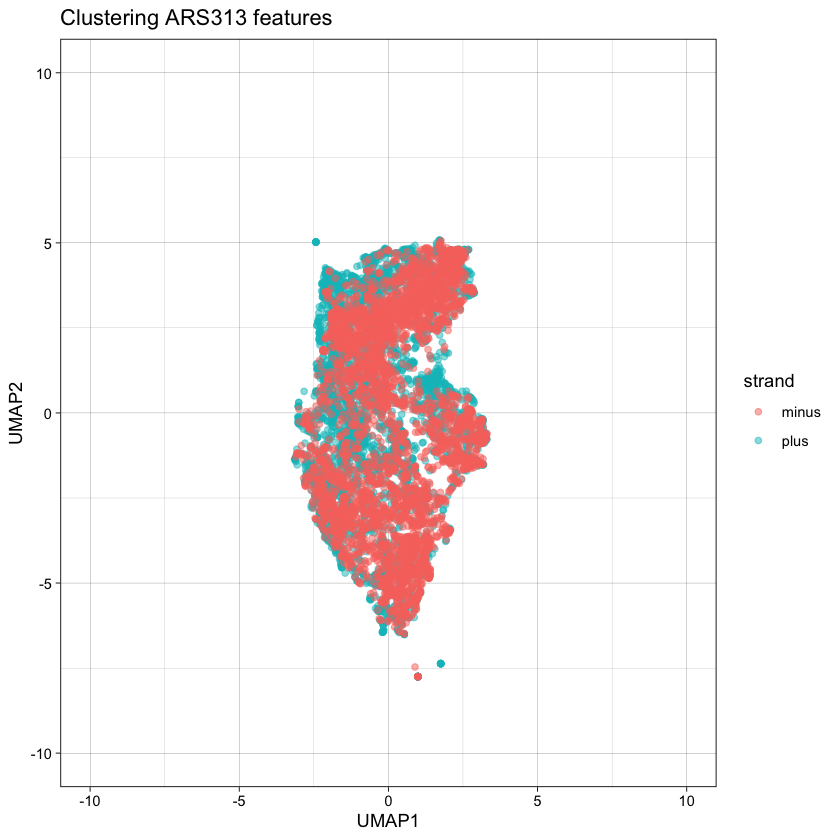

In [546]:
ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= strand)) + 
  theme_linedraw() + 
  geom_point(alpha = 0.5) +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

In [547]:
#set.seed(43)
#k <- kmeans(scaled_meth, centers= 2,
#            nstart = 10)  
## number of data points in each cluster
#table(k$cluster)

#quality of partition as Between sum of squares / total sum of squares
#100 * k$betweenss/k$totss

#sil <- silhouette(k$cluster, dist(scaled_meth))
#fviz_silhouette(sil) +
#  scale_fill_brewer(type = "qual", palette = "Set2")

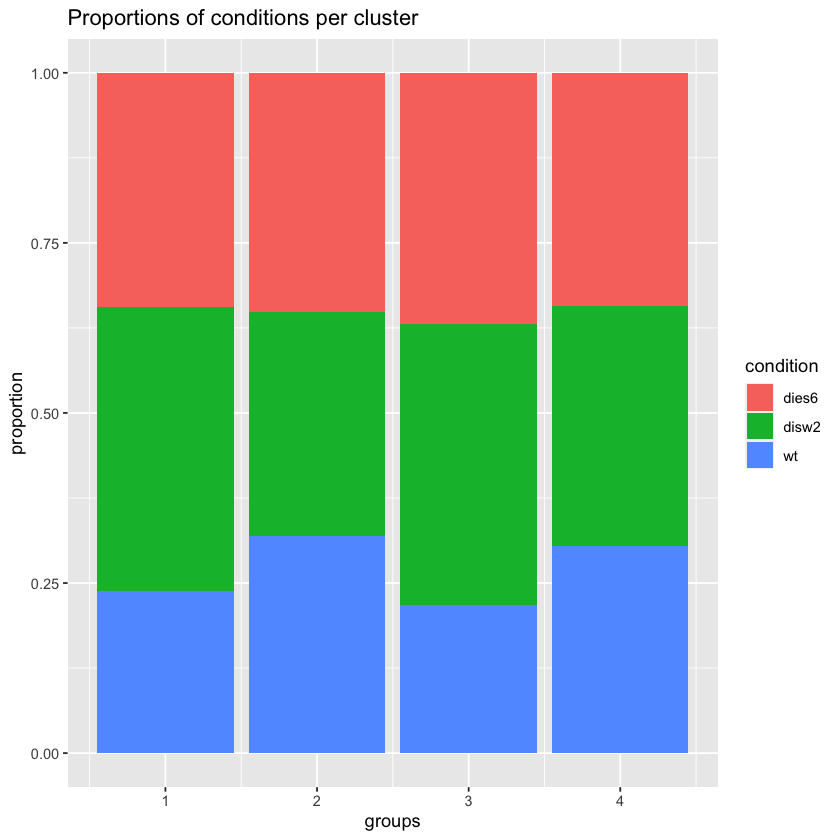

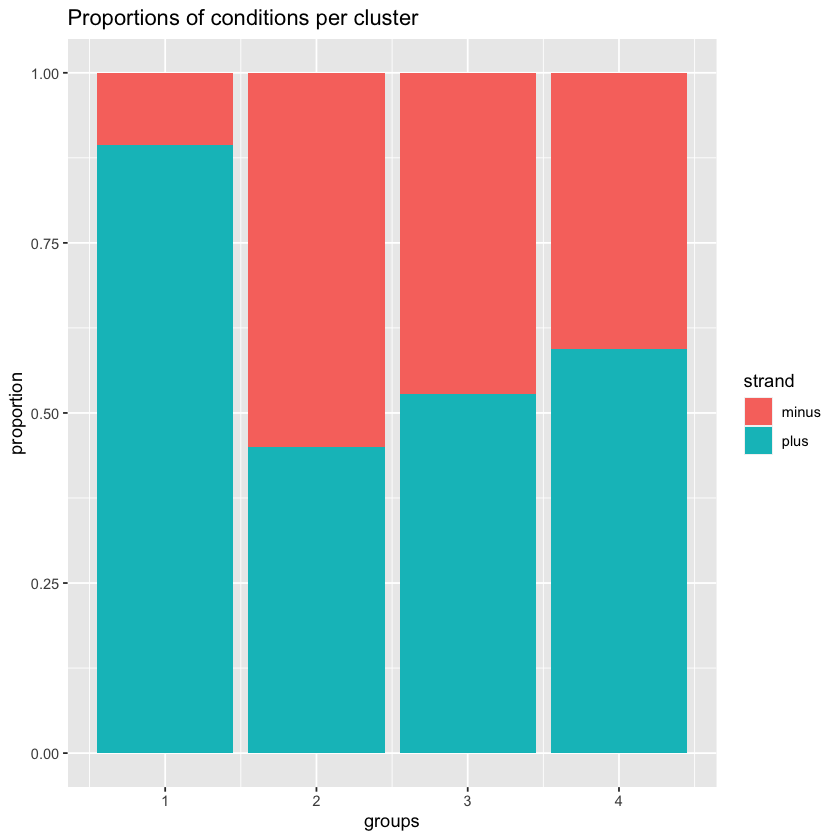

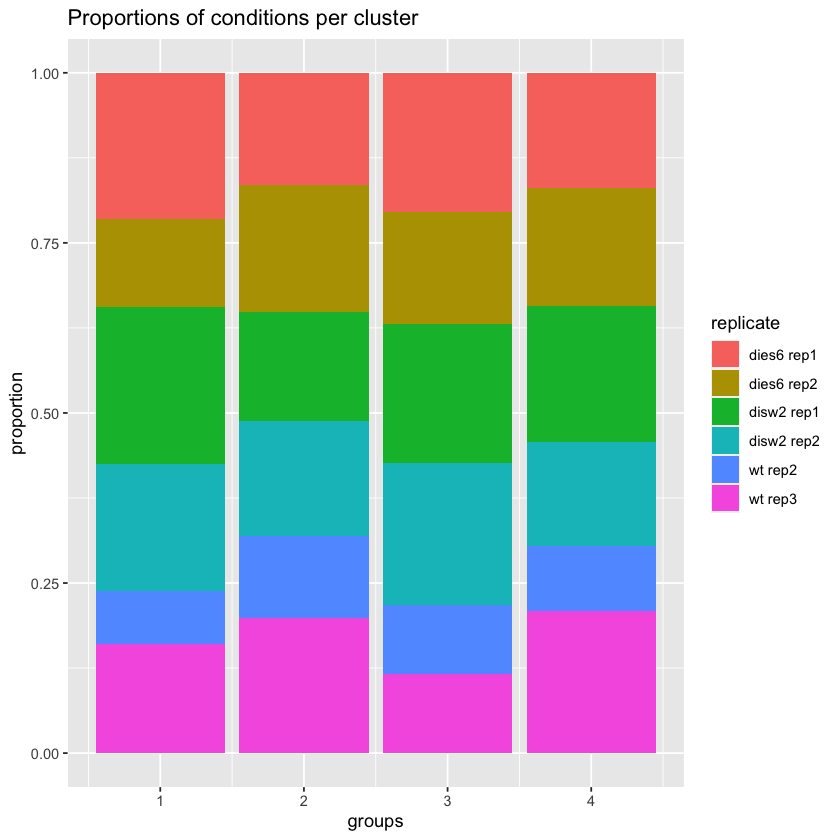

In [548]:
ggplot(data = aggr_data, aes(x = groups, fill = condition)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

ggplot(data = aggr_data, aes(x = groups, fill = strand)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

ggplot(data = aggr_data, aes(x = groups, fill = replicate)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

In [549]:
aggr_data$groups <- as.factor(aggr_data$groups)

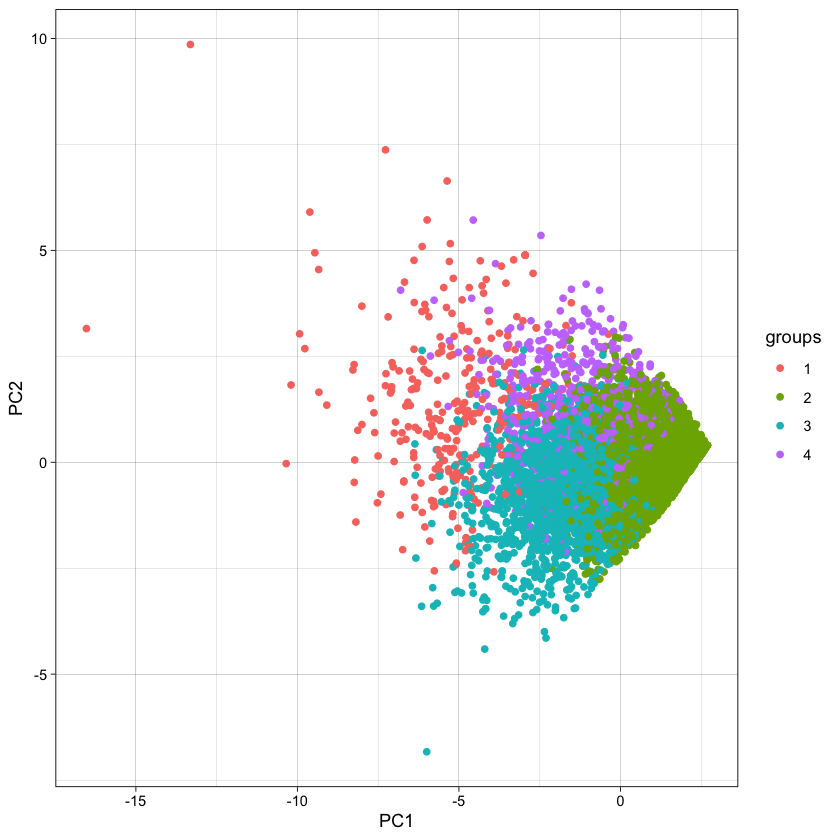

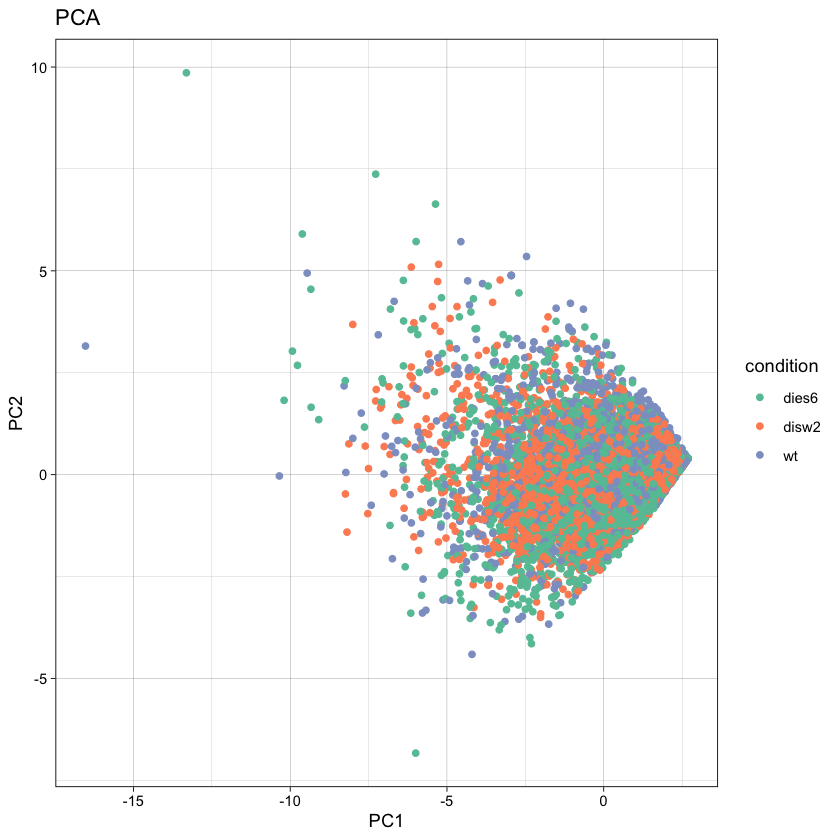

In [550]:
plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_data)

ggplot(plot_pc_aggr_data) + 
theme_linedraw() + 
geom_point(aes(x = PC1, y = PC2, color = groups)) 

ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
  theme_linedraw() + 
  geom_point() +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "PCA")

In [551]:
#aggr_data

col1 <- brewer.pal(6, "Set2")

heatmap(as.matrix(aggr_data[,3:12]), Colv=NA, Rowv= as.dendrogram(final_clust), scale = "none",
       main = "Scaled feature expression", RowSideColors = col1[groups]
       )

ERROR: Error in heatmap(as.matrix(aggr_data[, 3:12]), Colv = NA, Rowv = as.dendrogram(final_clust), : 'x' must be a numeric matrix


In [552]:
cor_mat <- cor(t(scaled_meth),method="spearman")
dissim_mat <- sqrt((1-cor_mat)/2)
dist_mat <- as.dist(dissim_mat)
corr_clust <- hclust(dist_mat, method="ward.D2")

#cut the dendrogram into 4 clusters
corr_groups <- cutree(corr_clust, k=4)
#corr_groups <- cutreeDynamic(corr_clust, distM=as.matrix(dissim_mat),
#                             method="hybrid", deepSplit = 0.05)

#find number of observations in each cluster
table(corr_groups)

corr_groups
   1    2    3    4 
2167 1457 2095 3065 

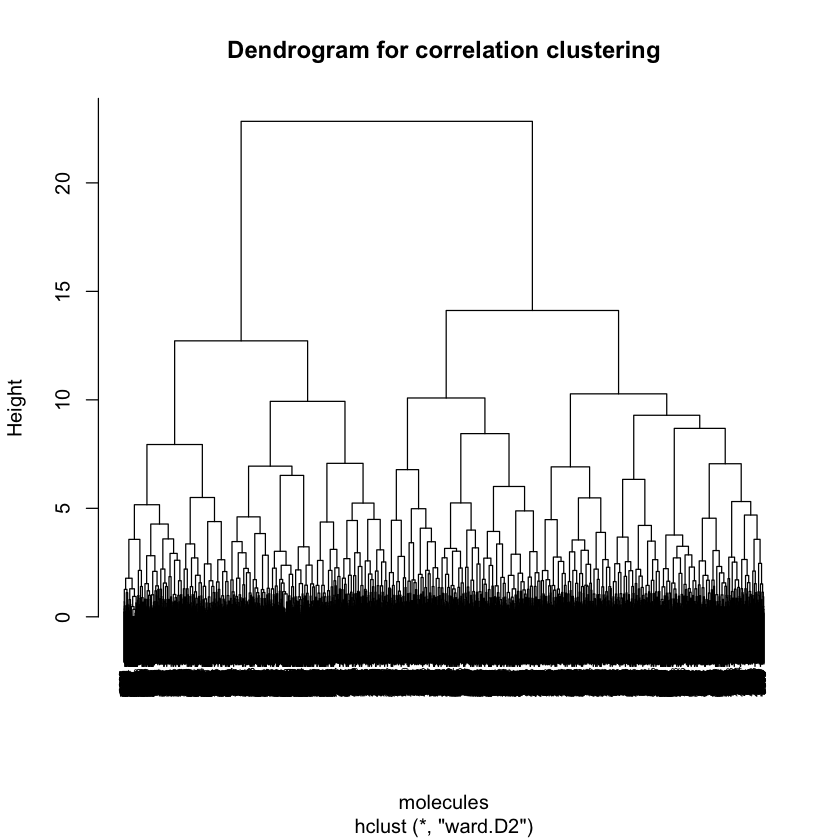

In [553]:
#pltree(corr_clust, cex = 0.6, hang = -1, main = "Dendrogram")
plot(x = corr_clust, cex = 0.5,  labels =  row.names(corr_clust), main = "Dendrogram for correlation clustering",
    xlab = "molecules")

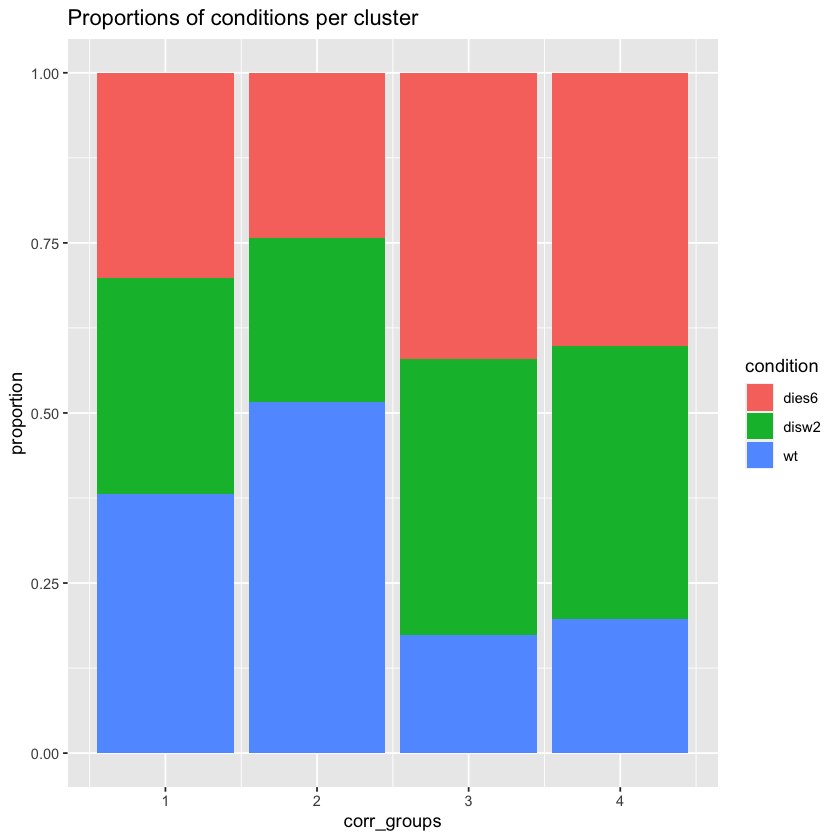

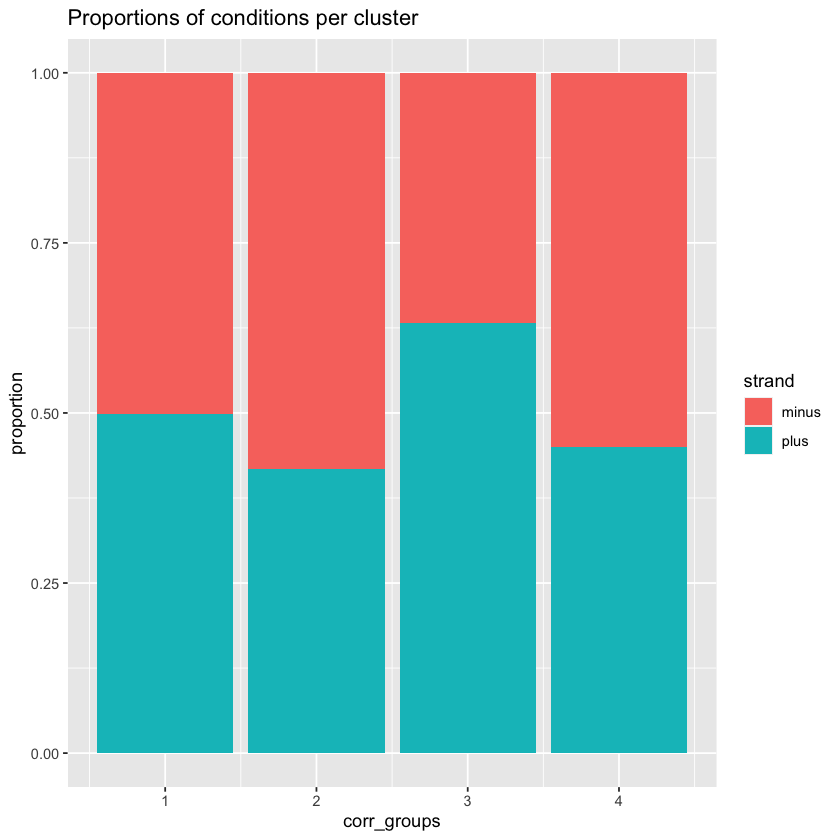

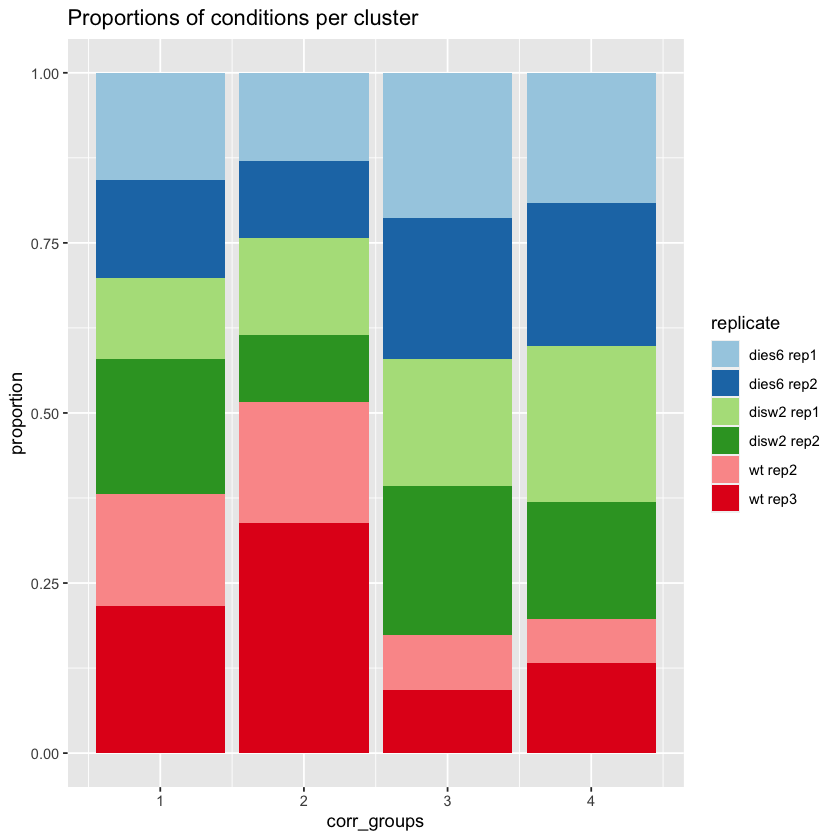

In [554]:
aggr_corr_data <- cbind(methylation_long, corr_groups)

ggplot(data = aggr_data, aes(x = corr_groups, fill = condition)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

ggplot(data = aggr_data, aes(x = corr_groups, fill = strand)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

ggplot(data = aggr_data, aes(x = corr_groups, fill = replicate)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster") + 
  scale_fill_brewer(type = "qual", palette = "Paired")

In [555]:
umap_corr <- umap(scaled_meth, metric = "correlation")

In [556]:
colnames(umap_corr) <- c("UMAP1", "UMAP2")

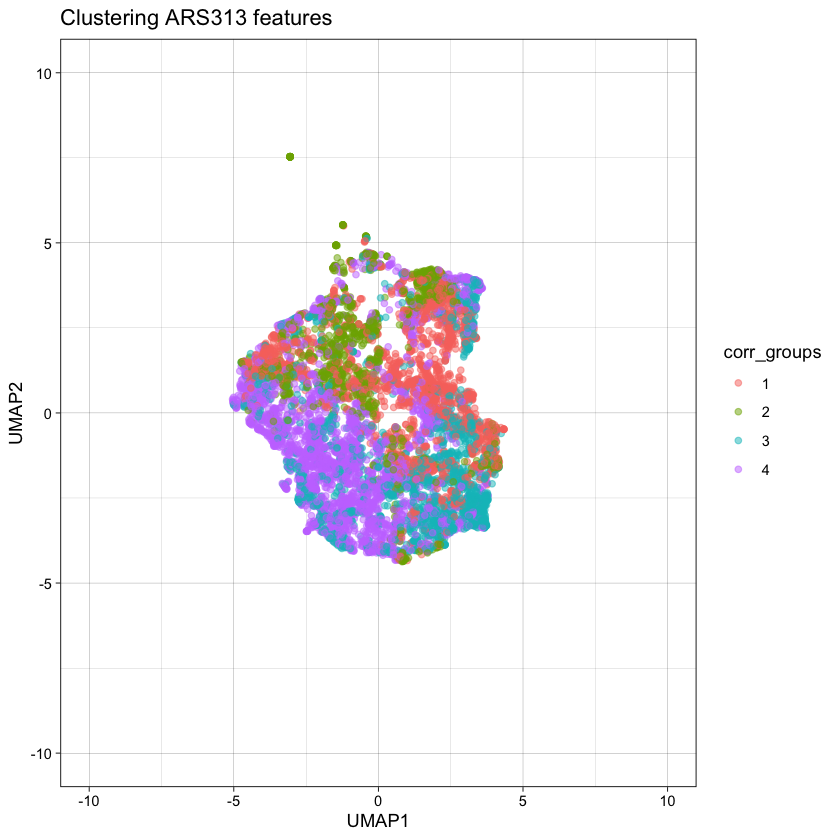

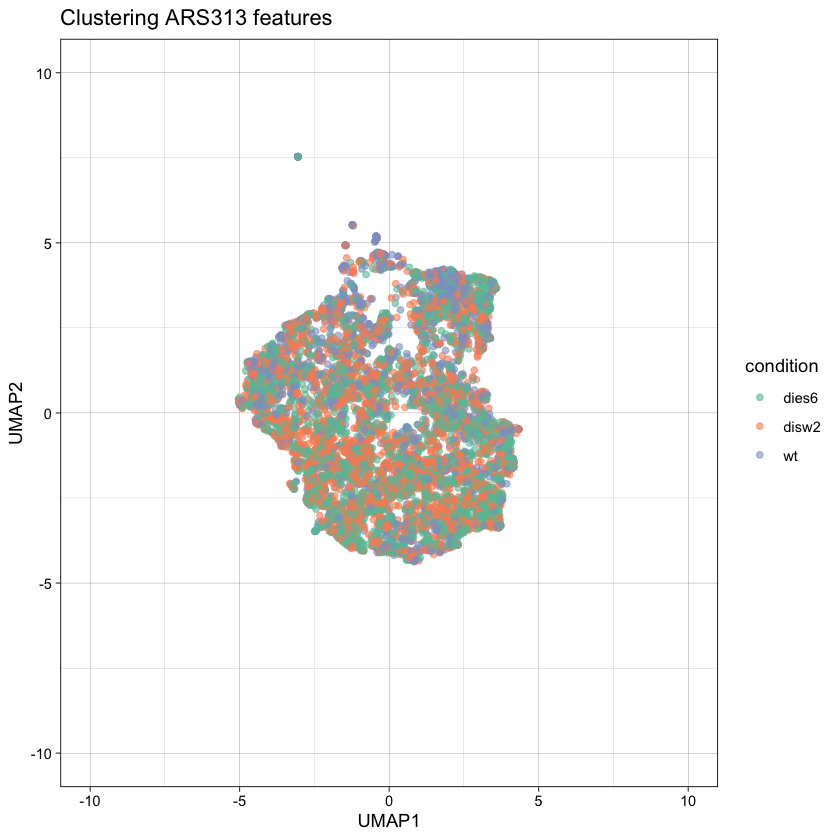

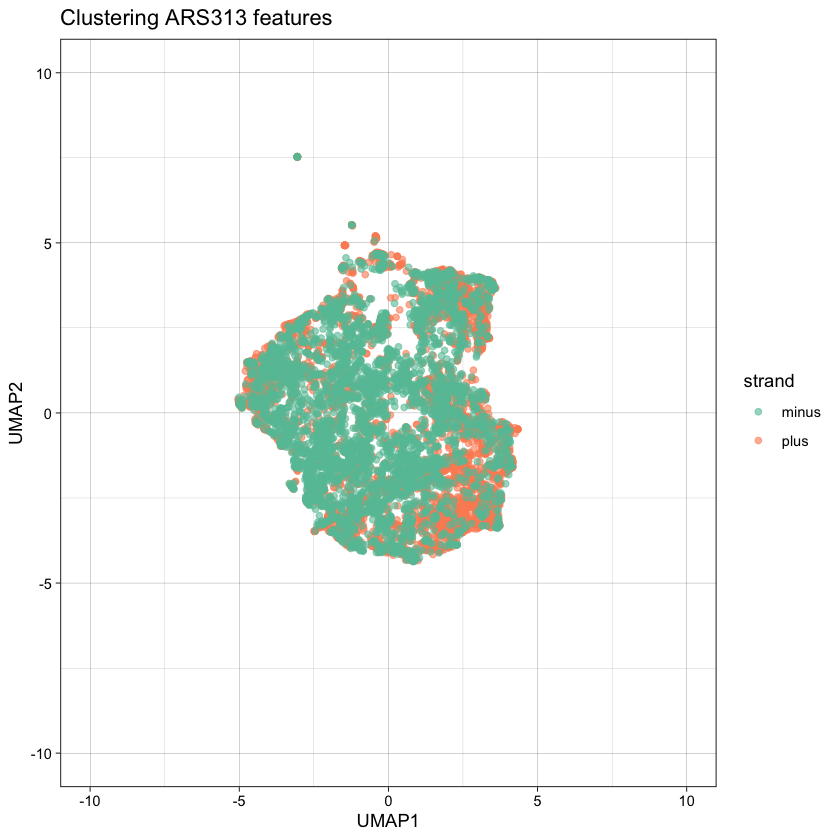

In [557]:
corr_plot_data <- cbind(umap_corr, aggr_corr_data)
corr_plot_data$corr_groups <- factor(corr_plot_data$corr_groups)

colnames(corr_plot_data)[1:2] = c("UMAP1", "UMAP2")

ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= corr_groups)) + 
  theme_linedraw() + 
  geom_point(alpha = 0.5) +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= strand)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

In [558]:
for( i in 1:ncol(scaled_meth)){
    print(range(scaled_meth[,i]))
    }


[1] -0.8358625 10.2128613
[1] -0.6940986 13.8544679
[1] -0.6000303  5.7917928
[1] -0.8299858 10.5262194
[1] -0.5716751  7.8627321
[1] -1.325327  8.498028
[1] -0.8147586  5.8596464
[1] -0.9830525  4.8981990
[1] -0.8768974  7.7571478
[1] -0.9732435  5.9179722


In [489]:
#col <- brewer.pal(10, "RdYlBu")
#col1 <- brewer.pal(6, "Set2")
#col2 <- brewer.pal(4, "Greys")
#col3 <- c("#ffffff", "#9fc5e8", "#16537e")

#heatmap(scaled_meth, Colv=NA, Rowv= as.dendrogram(corr_clust),
#        scale = "none",
#        main = "Scaled feature expression",
#        col = col2,
#        RowSideColors = col1[corr_groups]
#       )

In [490]:
#brewer.pal(5, "Dark2")
#brewer.pal(5, "Set2")
#brewer.pal(9, "Set1")

#col_Anna = ["black", "#0a22fa", "#f2180c"]

In [527]:
#introduce total methylation level as column to try this is the heatmap

#scaled_meth <- cbind(scaled_meth, rowSums(scaled_meth))
#colnames(scaled_meth)[ncol(scaled_meth)] = "total_meth"

In [532]:
aggr_corr_data$total_meth <- rowSums(aggr_corr_data[,5:14])
aggr_corr_data %>% group_by(corr_groups) %>% summarise(mean(total_meth))

corr_groups,mean(total_meth)
<fct>,<dbl>
1,11.504695
2,8.446245
3,13.080686
4,12.557838


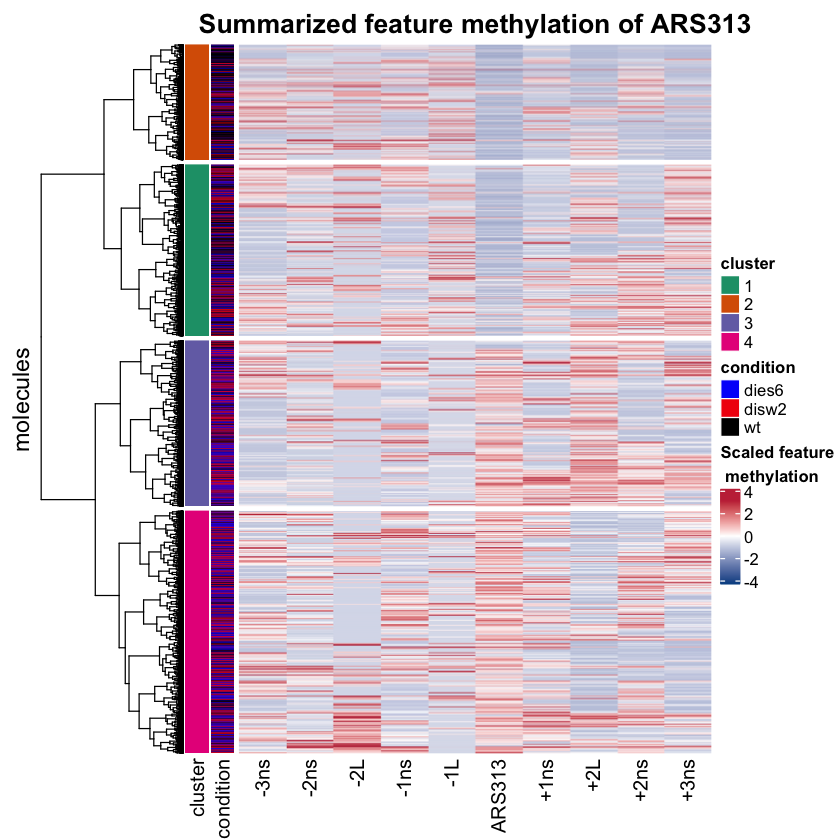

In [559]:
num_cluster <- length(unique(corr_groups))

col_list <- list(cluster = c("1" = '#1B9E77', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A', "5" = '#66A61E'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))
#Heatmap annotation
ha <- rowAnnotation(
    cluster = corr_groups, 
    condition = aggr_corr_data$condition, #insert replicate ?
    col = col_list 
)


color_func <- colorRamp2(c(-4,0,3), c("#0b5394", "white", "#c53145"))

Heatmap(scaled_meth, name = "Scaled feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
        row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS313", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )

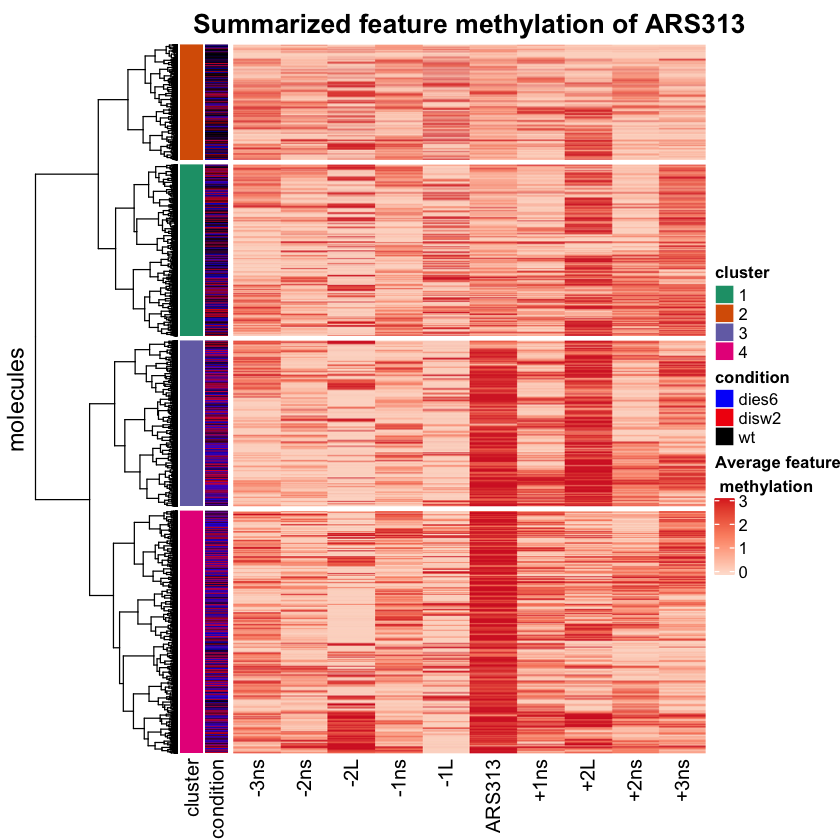

In [617]:
num_cluster <- length(unique(corr_groups))

col_list <- list(cluster = c("1" = '#1B9E77', "2" = '#D95F02', "3" = '#7570B3', "4" = '#E7298A'),#, "5" = '#66A61E'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))
#Heatmap annotation
ha <- rowAnnotation(
    cluster = aggr_corr_data$corr_groups, 
    condition = aggr_corr_data$condition,
    col = col_list 
)


color_func <- colorRamp2(c(0,1.5,3), brewer.pal(3, "Reds"))#c("#0b5394", "white", "#c53145"))
#aggr_corr_data %>% arrange(groups, condition)%>% select(c(5:14))

Heatmap(as.matrix(aggr_corr_data[,5:14]), name = "Average feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
       row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        #row_order = 
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS313", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )

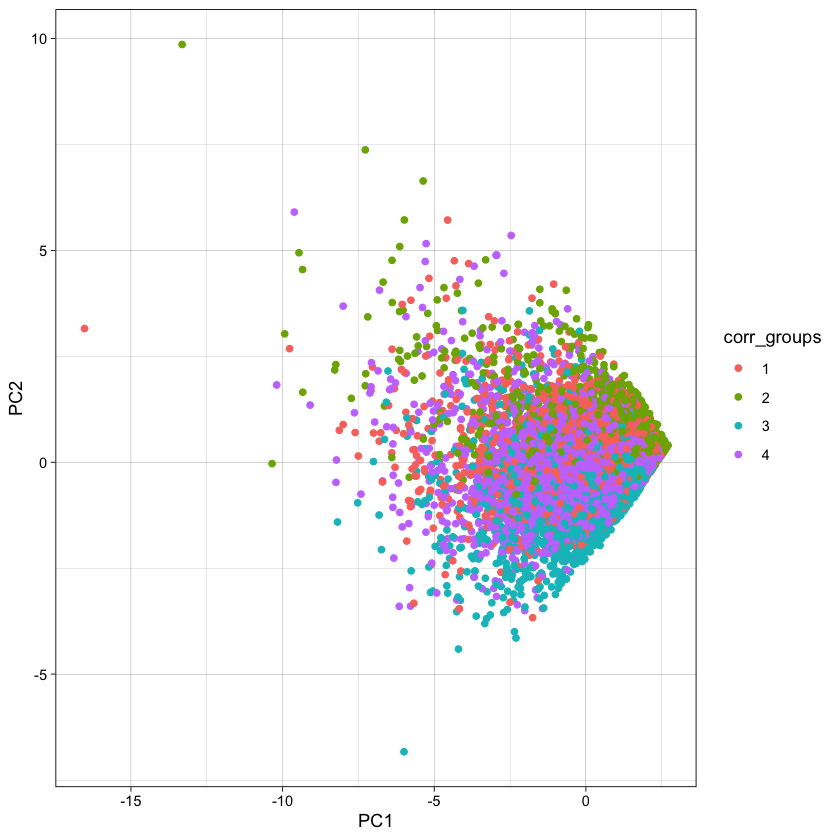

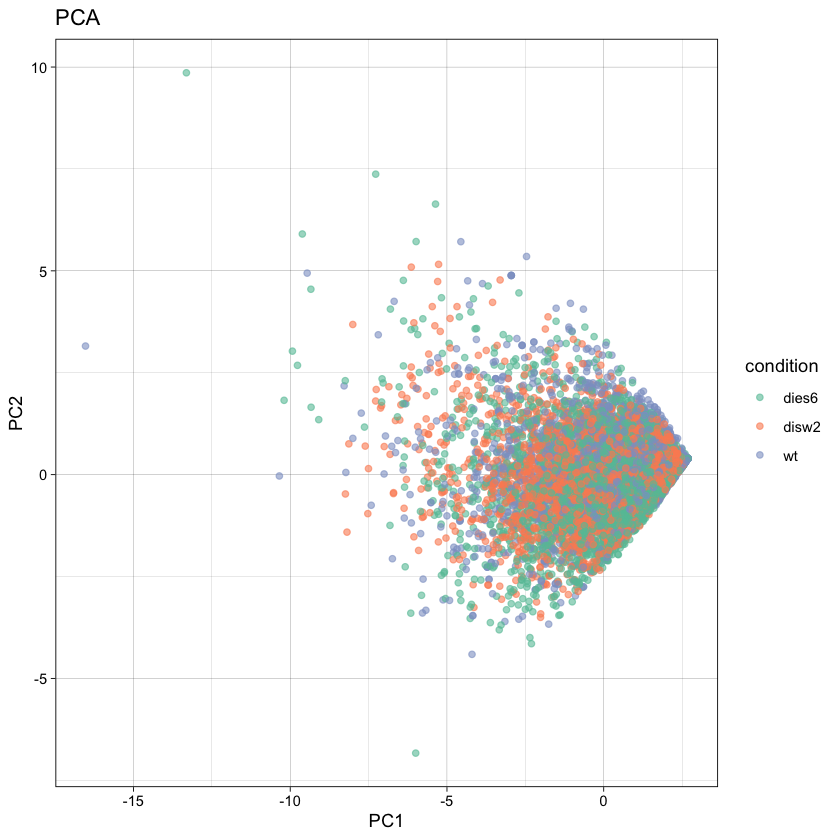

In [529]:
aggr_corr_data$corr_groups <- as.factor(aggr_corr_data$corr_groups)

plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_corr_data)

ggplot(plot_pc_aggr_data) + 
theme_linedraw() + 
geom_point(aes(x = PC1, y = PC2, color = corr_groups)) 

ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "PCA")